In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels
# y_test.shape, y_val.shape, y_train.shape
# X_train.shape, X_train.dtype, X_val.shape, X_val.dtype, X_test.shape, X_test.dtype

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [5]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # number of layers or depth
        self.losses = {'train':[], 'valid':[], 'valid_acc':[]}
        
        # The adaptive/learnable/updatable random feedforward
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.ys_prev = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
        # Previous output layer
        self.ys_prev.append(0.0)

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        # Previous output layer
        ys_prev_L = []
        for _ in range(L):
            ys_prev_L.append(0.0)
        self.ys_prev.append(ys_prev_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Outout layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        # Previous output layer
        self.ys_prev.append(0.0)
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
        dX = dout @ W.T # Backprop
#         dX = dout @ W_fixed.T # fb alignment

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
#         y = np.tanh(y)
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        ys.append(y) # ys[0]
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches, ys_L = [], [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
#             y = np.tanh(y)
            y, nl_cache = l.tanh_forward(X=y)
            ys_L.append(y) # ys[1][layer]
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        ys.append(ys_L) # ys[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        if train:
            caches.append(fc_cache)
        ys.append(y) # ys[2]

        return ys, caches # for backpropating the error

    def loss_function(self, y, y_train):
        
        loss = cross_entropy(y, y_train) # softmax is included
        dy = dcross_entropy(y, y_train) # dsoftmax is included
        
        return loss, dy
        
    def train_backward(self, dy, caches, ys):
        grads, ys_prev = self.grads, self.ys_prev # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache = caches[2]
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
#             dy *= ys[1][layer] - ys_prev[1][layer] # temporal diff instead of differentiable function
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
#         dy *= ys[0] - ys_prev[0] # temporal diff instead of differentiable function
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        ys_logit, _ = self.train_forward(X, train=False)
        y_logit = ys_logit[2] # last layer
        
        # if self.mode == 'classification':
        y_prob = l.softmax(y_logit) # for accuracy == acc
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_logit
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            ys, caches = self.train_forward(X_mini, train=True)
            loss, dy = self.loss_function(ys[2], y_mini)
            _, grads = self.train_backward(dy, caches, ys) # ys[0], ys[1] and ys_prev are used for backprop
            self.ys_prev = ys # for next iteration or epoch learning dW and db
            self.losses['train'].append(loss)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
                
            # Validate the updated model
            y_pred, y_logit = self.test(X_val)
            valid_loss, _ = self.loss_function(y_logit, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{} train loss: {:.4f} valid loss: {:.4f}, valid accuracy: {:.4f}'.format(
                    iter, loss, valid_loss, valid_acc))

        # Test the final model
        y_pred, y_logit = nn.test(X_test)
        loss, _ = self.loss_function(y_logit, y_test) # softmax is included in entropy loss function
        acc = np.mean(y_pred == y_test)
        print('Last iteration - Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.format(
            acc.mean(), acc.std(), loss))

In [6]:
# Hyper-parameters
n_iter = 100000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 100 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-100 train loss: 2.2674 valid loss: 2.2775, valid accuracy: 0.1692
Iter-200 train loss: 2.2481 valid loss: 2.2430, valid accuracy: 0.2560
Iter-300 train loss: 2.2605 valid loss: 2.2090, valid accuracy: 0.3276
Iter-400 train loss: 2.1635 valid loss: 2.1769, valid accuracy: 0.3754
Iter-500 train loss: 2.1474 valid loss: 2.1446, valid accuracy: 0.4078
Iter-600 train loss: 2.1095 valid loss: 2.1130, valid accuracy: 0.4358
Iter-700 train loss: 2.1137 valid loss: 2.0819, valid accuracy: 0.4554
Iter-800 train loss: 2.0167 valid loss: 2.0513, valid accuracy: 0.4728
Iter-900 train loss: 2.0292 valid loss: 2.0211, valid accuracy: 0.4842
Iter-1000 train loss: 1.9572 valid loss: 1.9906, valid accuracy: 0.4976
Iter-1100 train loss: 1.9891 valid loss: 1.9607, valid accuracy: 0.5074
Iter-1200 train loss: 1.9874 valid loss: 1.9307, valid accuracy: 0.5138
Iter-1300 train loss: 1.8727 valid loss: 1.9015, valid accuracy: 0.5214
Iter-1400 train loss: 1.9988 valid loss: 1.8722, valid accuracy: 0.5288
I

Iter-11500 train loss: 0.5169 valid loss: 0.5867, valid accuracy: 0.8712
Iter-11600 train loss: 0.5712 valid loss: 0.5829, valid accuracy: 0.8720
Iter-11700 train loss: 0.6542 valid loss: 0.5790, valid accuracy: 0.8722
Iter-11800 train loss: 0.6261 valid loss: 0.5754, valid accuracy: 0.8724
Iter-11900 train loss: 0.4155 valid loss: 0.5718, valid accuracy: 0.8728
Iter-12000 train loss: 0.6471 valid loss: 0.5682, valid accuracy: 0.8740
Iter-12100 train loss: 0.4579 valid loss: 0.5645, valid accuracy: 0.8744
Iter-12200 train loss: 0.6255 valid loss: 0.5610, valid accuracy: 0.8744
Iter-12300 train loss: 0.6339 valid loss: 0.5575, valid accuracy: 0.8752
Iter-12400 train loss: 0.5578 valid loss: 0.5542, valid accuracy: 0.8760
Iter-12500 train loss: 0.6614 valid loss: 0.5506, valid accuracy: 0.8764
Iter-12600 train loss: 0.9034 valid loss: 0.5473, valid accuracy: 0.8768
Iter-12700 train loss: 0.4852 valid loss: 0.5442, valid accuracy: 0.8782
Iter-12800 train loss: 0.3894 valid loss: 0.5411, v

Iter-22800 train loss: 0.2948 valid loss: 0.3778, valid accuracy: 0.9026
Iter-22900 train loss: 0.2804 valid loss: 0.3769, valid accuracy: 0.9020
Iter-23000 train loss: 0.3858 valid loss: 0.3762, valid accuracy: 0.9020
Iter-23100 train loss: 0.5381 valid loss: 0.3753, valid accuracy: 0.9020
Iter-23200 train loss: 0.4316 valid loss: 0.3744, valid accuracy: 0.9022
Iter-23300 train loss: 0.2531 valid loss: 0.3737, valid accuracy: 0.9026
Iter-23400 train loss: 0.4643 valid loss: 0.3731, valid accuracy: 0.9026
Iter-23500 train loss: 0.4012 valid loss: 0.3723, valid accuracy: 0.9024
Iter-23600 train loss: 0.2693 valid loss: 0.3718, valid accuracy: 0.9022
Iter-23700 train loss: 0.2254 valid loss: 0.3708, valid accuracy: 0.9022
Iter-23800 train loss: 0.4064 valid loss: 0.3700, valid accuracy: 0.9024
Iter-23900 train loss: 0.3118 valid loss: 0.3694, valid accuracy: 0.9024
Iter-24000 train loss: 0.4918 valid loss: 0.3687, valid accuracy: 0.9020
Iter-24100 train loss: 0.3042 valid loss: 0.3678, v

Iter-34100 train loss: 0.3666 valid loss: 0.3154, valid accuracy: 0.9130
Iter-34200 train loss: 0.3991 valid loss: 0.3150, valid accuracy: 0.9128
Iter-34300 train loss: 0.2050 valid loss: 0.3145, valid accuracy: 0.9132
Iter-34400 train loss: 0.6333 valid loss: 0.3141, valid accuracy: 0.9128
Iter-34500 train loss: 0.5686 valid loss: 0.3139, valid accuracy: 0.9126
Iter-34600 train loss: 0.3746 valid loss: 0.3135, valid accuracy: 0.9130
Iter-34700 train loss: 0.3010 valid loss: 0.3131, valid accuracy: 0.9124
Iter-34800 train loss: 0.4007 valid loss: 0.3126, valid accuracy: 0.9132
Iter-34900 train loss: 0.2138 valid loss: 0.3123, valid accuracy: 0.9134
Iter-35000 train loss: 0.6684 valid loss: 0.3118, valid accuracy: 0.9142
Iter-35100 train loss: 0.2966 valid loss: 0.3112, valid accuracy: 0.9142
Iter-35200 train loss: 0.3290 valid loss: 0.3109, valid accuracy: 0.9142
Iter-35300 train loss: 0.2106 valid loss: 0.3105, valid accuracy: 0.9144
Iter-35400 train loss: 0.3616 valid loss: 0.3100, v

Iter-45400 train loss: 0.3624 valid loss: 0.2827, valid accuracy: 0.9202
Iter-45500 train loss: 0.2520 valid loss: 0.2827, valid accuracy: 0.9200
Iter-45600 train loss: 0.2351 valid loss: 0.2822, valid accuracy: 0.9200
Iter-45700 train loss: 0.1338 valid loss: 0.2820, valid accuracy: 0.9194
Iter-45800 train loss: 0.3376 valid loss: 0.2819, valid accuracy: 0.9192
Iter-45900 train loss: 0.1467 valid loss: 0.2818, valid accuracy: 0.9198
Iter-46000 train loss: 0.2095 valid loss: 0.2815, valid accuracy: 0.9202
Iter-46100 train loss: 0.2189 valid loss: 0.2814, valid accuracy: 0.9200
Iter-46200 train loss: 0.2221 valid loss: 0.2813, valid accuracy: 0.9200
Iter-46300 train loss: 0.3051 valid loss: 0.2811, valid accuracy: 0.9202
Iter-46400 train loss: 0.1813 valid loss: 0.2810, valid accuracy: 0.9202
Iter-46500 train loss: 0.4076 valid loss: 0.2808, valid accuracy: 0.9206
Iter-46600 train loss: 0.2940 valid loss: 0.2806, valid accuracy: 0.9208
Iter-46700 train loss: 0.2404 valid loss: 0.2804, v

Iter-56700 train loss: 0.2413 valid loss: 0.2618, valid accuracy: 0.9258
Iter-56800 train loss: 0.3071 valid loss: 0.2616, valid accuracy: 0.9262
Iter-56900 train loss: 0.3254 valid loss: 0.2613, valid accuracy: 0.9260
Iter-57000 train loss: 0.2210 valid loss: 0.2611, valid accuracy: 0.9266
Iter-57100 train loss: 0.1897 valid loss: 0.2610, valid accuracy: 0.9270
Iter-57200 train loss: 0.3724 valid loss: 0.2610, valid accuracy: 0.9264
Iter-57300 train loss: 0.1617 valid loss: 0.2608, valid accuracy: 0.9260
Iter-57400 train loss: 0.1520 valid loss: 0.2608, valid accuracy: 0.9260
Iter-57500 train loss: 0.2804 valid loss: 0.2610, valid accuracy: 0.9262
Iter-57600 train loss: 0.4790 valid loss: 0.2608, valid accuracy: 0.9264
Iter-57700 train loss: 0.2890 valid loss: 0.2606, valid accuracy: 0.9266
Iter-57800 train loss: 0.2351 valid loss: 0.2605, valid accuracy: 0.9266
Iter-57900 train loss: 0.2157 valid loss: 0.2603, valid accuracy: 0.9262
Iter-58000 train loss: 0.3032 valid loss: 0.2600, v

Iter-68000 train loss: 0.3365 valid loss: 0.2452, valid accuracy: 0.9302
Iter-68100 train loss: 0.2091 valid loss: 0.2452, valid accuracy: 0.9298
Iter-68200 train loss: 0.1815 valid loss: 0.2453, valid accuracy: 0.9294
Iter-68300 train loss: 0.3544 valid loss: 0.2449, valid accuracy: 0.9296
Iter-68400 train loss: 0.3415 valid loss: 0.2447, valid accuracy: 0.9298
Iter-68500 train loss: 0.2254 valid loss: 0.2447, valid accuracy: 0.9298
Iter-68600 train loss: 0.4278 valid loss: 0.2447, valid accuracy: 0.9300
Iter-68700 train loss: 0.2742 valid loss: 0.2445, valid accuracy: 0.9300
Iter-68800 train loss: 0.3473 valid loss: 0.2443, valid accuracy: 0.9302
Iter-68900 train loss: 0.1573 valid loss: 0.2441, valid accuracy: 0.9304
Iter-69000 train loss: 0.1319 valid loss: 0.2440, valid accuracy: 0.9304
Iter-69100 train loss: 0.3436 valid loss: 0.2440, valid accuracy: 0.9306
Iter-69200 train loss: 0.1660 valid loss: 0.2439, valid accuracy: 0.9308
Iter-69300 train loss: 0.0934 valid loss: 0.2437, v

Iter-79300 train loss: 0.1687 valid loss: 0.2317, valid accuracy: 0.9328
Iter-79400 train loss: 0.2984 valid loss: 0.2315, valid accuracy: 0.9326
Iter-79500 train loss: 0.1208 valid loss: 0.2313, valid accuracy: 0.9334
Iter-79600 train loss: 0.2383 valid loss: 0.2311, valid accuracy: 0.9338
Iter-79700 train loss: 0.1928 valid loss: 0.2311, valid accuracy: 0.9334
Iter-79800 train loss: 0.2310 valid loss: 0.2307, valid accuracy: 0.9338
Iter-79900 train loss: 0.2269 valid loss: 0.2305, valid accuracy: 0.9338
Iter-80000 train loss: 0.2629 valid loss: 0.2304, valid accuracy: 0.9338
Iter-80100 train loss: 0.3131 valid loss: 0.2304, valid accuracy: 0.9340
Iter-80200 train loss: 0.2844 valid loss: 0.2302, valid accuracy: 0.9340
Iter-80300 train loss: 0.2273 valid loss: 0.2302, valid accuracy: 0.9336
Iter-80400 train loss: 0.1698 valid loss: 0.2301, valid accuracy: 0.9338
Iter-80500 train loss: 0.3594 valid loss: 0.2302, valid accuracy: 0.9338
Iter-80600 train loss: 0.5105 valid loss: 0.2302, v

Iter-90600 train loss: 0.1811 valid loss: 0.2201, valid accuracy: 0.9374
Iter-90700 train loss: 0.3121 valid loss: 0.2201, valid accuracy: 0.9366
Iter-90800 train loss: 0.0992 valid loss: 0.2199, valid accuracy: 0.9368
Iter-90900 train loss: 0.1964 valid loss: 0.2198, valid accuracy: 0.9374
Iter-91000 train loss: 0.3304 valid loss: 0.2197, valid accuracy: 0.9370
Iter-91100 train loss: 0.2286 valid loss: 0.2196, valid accuracy: 0.9376
Iter-91200 train loss: 0.3053 valid loss: 0.2195, valid accuracy: 0.9372
Iter-91300 train loss: 0.1651 valid loss: 0.2193, valid accuracy: 0.9372
Iter-91400 train loss: 0.0877 valid loss: 0.2192, valid accuracy: 0.9374
Iter-91500 train loss: 0.1954 valid loss: 0.2192, valid accuracy: 0.9376
Iter-91600 train loss: 0.1390 valid loss: 0.2191, valid accuracy: 0.9368
Iter-91700 train loss: 0.3620 valid loss: 0.2191, valid accuracy: 0.9366
Iter-91800 train loss: 0.2553 valid loss: 0.2191, valid accuracy: 0.9370
Iter-91900 train loss: 0.2430 valid loss: 0.2192, v

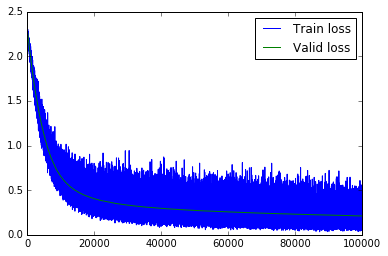

In [7]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.legend()
plt.show()

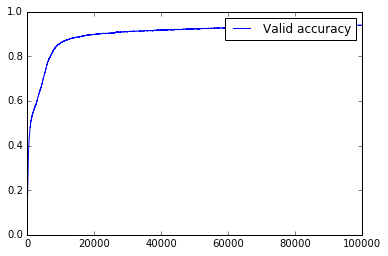

In [8]:
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.legend()
plt.show()